In [1]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

from ast import literal_eval

import seaborn as sns

from SGanalysis.SGobject import SGobject
from adjustText import adjust_text

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text

from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'
tools_path = '../helperScripts/tools.py'
# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'

# /Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [2]:
## load data for the roi of interest    
roi_of_interest = 'roi_2'

# load the sg_object
with open(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

# load the dataframes with the cell by gene matrices, clustered and unclustered
unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')



In [3]:
unclustered_df =  pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_atleast3.csv')
clustered_df = pd.read_csv(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/cell_by_gene_matrix_dilate10_20240718_withbarcodes_clustering_10bcs_0.4thresh.csv')


In [4]:
# merge the clustered and unclustered dataframes
cols_to_keep = ['object_id','bc_cluster','bc_cluster_n_bcs','bc_cluster_found_bcs','bc_cluster_bc_names']
df = unclustered_df.merge(clustered_df[cols_to_keep],on='object_id',how='left')   

In [5]:
df['cell_id'] = [str(id) for id in df['object_id']]

# sg_obj.gdf['cell_id'] = [str(x) for x in sg_obj.gdf['object_id']]
sg_obj.gdf['object_id'] = sg_obj.gdf.index
sg_obj.gdf['cell_id'] = sg_obj.gdf['object_id'].astype('string')
sg_obj.gdf.index.name = 'index'
sg_obj.gdf = sg_obj.gdf.sort_values('object_id')

# assign clusters to the sg_obj
sg_obj.gdf = sg_obj.gdf.merge(df[['cell_id']+list(df.columns.difference(sg_obj.gdf.columns))],on=['cell_id'],how='left')

In [6]:
gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','object_id','area','called_barcodes','n_called_barcodes','barcode_names','area','center_x','center_y','nucleus','nucleus_centroid','nucleus_dilated']]    


In [7]:
# assign all nan_sg_obj to -1
sg_obj.gdf['bc_cluster'] = sg_obj.gdf['bc_cluster'].fillna(-1)

In [8]:
sg_obj

plt.get_cmap('tab20c')

In [9]:
# roi_of_interest = 'roi_2'
spots_df = pd.read_csv(tools.roi_file_paths[roi_of_interest]["spots_file"])

<Figure size 640x480 with 0 Axes>

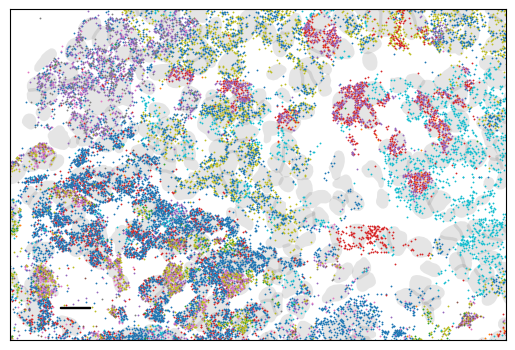

In [10]:
### zoom in to a region of interest

# xlims = [20000,22000]
# ylims = [3000,5000]


# xlims = [30000,35000]
# ylims = [7000,12000]


# xlims = [31000,33000]
# ylims = [7000,9000]

box_xlims = [30000,33000]
box_ylims = [7000,9000]


spots_within = spots_df[(spots_df['x']>box_xlims[0]) & (spots_df['x']<box_xlims[1]) & (spots_df['y']>box_ylims[0]) & (spots_df['y']<box_ylims[1])]

bc_cols = [col for col in df.columns if 'bc_' in col and 'cluster' not in col]
plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.2)

for gene_of_interest in bc_cols:

    # get the spots for the gene of interest
    spots_gene = spots_within[spots_within['name']==gene_of_interest]

    plt.scatter(spots_gene['x'],spots_gene['y'],s=7,alpha=1.0,lw=0,marker='.')

# plt.axis('off')
plt.gca().tick_params(bottom=False, left=False)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
# plt.title(gene_of_interest)
# plt.gca().invert_yaxis()
    
plt.xlim(box_xlims[0],box_xlims[1])
plt.ylim(box_ylims[0],box_ylims[1])


scale_bar_length_um = 20 # 100um scale bar
scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
scale_bar = matplotlib.patches.Rectangle((box_xlims[0]+(0.1*(box_xlims[1]-box_xlims[0])),box_ylims[1]-(0.1*(box_ylims[1]-box_ylims[0]))), 
                                         scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
plt.gca().add_patch(scale_bar)

plt.gca().invert_yaxis()


plt.savefig(f'../graphs/in_vivo_barcode_transcripts_zoom.pdf',bbox_inches='tight',transparent=True)
# plt.savefig(f'../graphs/in_vivo_barcode_transcripts.png',dpi=1000,bbox_inches='tight',transparent=True)


<Figure size 640x480 with 0 Axes>

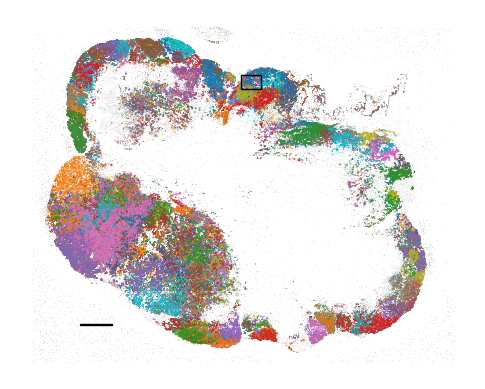

In [11]:
# plt.figure()

bc_cols = [col for col in df.columns if 'bc_' in col and 'cluster' not in col]
plt.figure()
sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)

for gene_of_interest in bc_cols:
    # get the spots for the gene of interest
    spots_gene = spots_df[spots_df['name']==gene_of_interest]

    plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0)



# draw rectangle of where the inset box will be
# xlims = [30000,33000]
# ylims = [7000,9000]

rect = matplotlib.patches.Rectangle((box_xlims[0],box_ylims[0]), box_xlims[1]-box_xlims[0], box_ylims[1]-box_ylims[0], linewidth=1, edgecolor='k', facecolor='none')
plt.gca().add_patch(rect)

xlims = plt.xlim()
ylims = plt.ylim()

# add scale bar
scale_bar_length_um = 500 # 500um scale bar
scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
scale_bar = matplotlib.patches.Rectangle((xlims[0]+(0.15*(xlims[1]-xlims[0])),ylims[1]-(0.15*(ylims[1]-ylims[0]))), 
                                         scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
plt.gca().add_patch(scale_bar)

plt.gca().invert_yaxis()
plt.axis('off')

# plt.gca().tick_params(left=False, bottom=False)

# plt.savefig(f'../graphs/space_VEGFA_MITF_full.pdf',bbox_inches='tight',transparent=True)
plt.savefig(f'../graphs/in_vivo_barcode_transcripts_insetbox.png',dpi=1000,bbox_inches='tight',transparent=True)

    

In [12]:
# plot transcript detection for other ROIs

## load data for the roi of interest    


for roi_of_interest in ['roi_1','roi_3','run2_roi_2','run2_roi_3']:

    spots_df = pd.read_csv(tools.roi_file_paths[roi_of_interest]["spots_file"])

    # load the sg_object
    with open(f'{tools.roi_file_paths[roi_of_interest]["out_path"]}/sg_object_dilate10_20240718.pkl', 'rb') as f:
        sg_obj = pickle.load(f)

    bc_cols = [col for col in df.columns if 'bc_' in col and 'cluster' not in col]
    plt.figure()
    sg_obj.gdf.plot(color='gray',lw=0.01,alpha=0.1)

    for gene_of_interest in bc_cols:

        # get the spots for the gene of interest
        spots_gene = spots_df[spots_df['name']==gene_of_interest]

        plt.scatter(spots_gene['x'],spots_gene['y'],s=0.1,alpha=0.4,lw=0)

    plt.axis('off')
    # plt.title(gene_of_interest)
    xlims = plt.xlim()
    ylims = plt.ylim()

    # add scale bar
    scale_bar_length_um = 500 # 500um scale bar
    scale_bar_length_px = int(scale_bar_length_um * 1000.0 / tools.sg_pixel_size)  # px
    scale_bar = matplotlib.patches.Rectangle((xlims[0]+(0.15*(xlims[1]-xlims[0])),ylims[1]-(0.15*(ylims[1]-ylims[0]))), 
                                            scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='k', facecolor='k')
    plt.gca().add_patch(scale_bar)



    plt.gca().invert_yaxis()

    # plt.savefig(f'../graphs/space_VEGFA_MITF_full.pdf',bbox_inches='tight',transparent=True)
    plt.savefig(f'../graphs/in_vivo_barcode_transcripts_{roi_of_interest}_scalebar.png',dpi=1000,bbox_inches='tight',transparent=True)



